# Mixture of Factor Analyzers for LLM Activation Decomposition

**Paper**: [From Directions to Regions: Decomposing Activations in Language Models via Local Geometry](https://arxiv.org/abs/2602.02464) (Shafran et al., 2025)

## Core Idea

Existing interpretability methods assume concepts live along **single global directions** (linear probes, SAE features, DiffMean). But many concepts have **nonlinear** structure—they're spread across clusters with different local orientations.

**Mixture of Factor Analyzers (MFA)** models activation space as a collection of **Gaussian regions**, each with its own centroid and local low-rank subspace. Every activation decomposes into:

1. **Centroid** $\mu_k$: *which region* the activation belongs to (broad semantic category)
2. **Local offset** $W_k z_k$: *variation within* that region (fine-grained distinctions)

### Why this matters

- **Steering**: Centroid interpolation steers toward broad concepts; local offsets refine within a concept. MFA often outperforms SAEs on causal steering benchmarks.
- **Interpretability**: MFA decompositions have ~96% interpretable feature mass (vs ~29% for SAEs).
- **Structure discovery**: Reveals that concepts organize into multi-Gaussian neighborhoods (e.g., an "emotions" cluster contains sub-Gaussians for happiness, surprise, anger).

### The Model

**Factor Analysis (single component):**
$$x = \mu + Wz + \epsilon, \quad z \sim \mathcal{N}(0, I_R), \quad \epsilon \sim \mathcal{N}(0, \Psi)$$

where $W \in \mathbb{R}^{D \times R}$ maps $R$ latent factors to $D$-dimensional activation space, and $\Psi$ is diagonal noise.

**Mixture of Factor Analyzers:**
$$p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, W_k W_k^\top + \Psi)$$

Each component $k$ has its own centroid $\mu_k$ and loading matrix $W_k$, but they share noise $\Psi$.

**Decomposition** of an activation $x$:
$$x \approx \underbrace{\mu_k}_{\text{centroid}} + \underbrace{W_k \hat{z}_k}_{\text{local offset}} + \underbrace{\epsilon}_{\text{noise}}$$

where $k = \arg\max_j R_j(x)$ is the most likely component, and $\hat{z}_k$ is the posterior mean of the latent.

### Exercise Overview

You will:
1. **Extract activations** from a small LLM
2. **Implement Factor Analysis** (the single-component building block)
3. **Implement MFA** (mixture of FAs with K-means initialization)
4. **Decompose activations** into centroid + local offset + noise
5. **Interpret components**: inspect centroids and loading directions via logit lens
6. **Steer with MFA**: compare centroid intervention vs local offset intervention

Estimated time: ~45 minutes

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jaxtyping import Float
from torch import Tensor
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Part 1: Extract Activations

In [2]:
from nnsight import LanguageModel
from datasets import load_dataset

model_name = "HuggingFaceTB/SmolLM2-135M"
model = LanguageModel(model_name, device_map=device, dispatch=True)
tokenizer = model.tokenizer
tokenizer.pad_token = tokenizer.eos_token

n_layers = model.config.num_hidden_layers
d_model = model.config.hidden_size
target_layer = n_layers // 3

print(f"Model: {model_name}")
print(f"Layers: {n_layers}, d_model: {d_model}")
print(f"Extracting from layer {target_layer}")

Loading weights:   0%|          | 0/272 [00:00<?, ?it/s]

Model: HuggingFaceTB/SmolLM2-135M
Layers: 30, d_model: 576
Extracting from layer 10


In [3]:
ds = load_dataset(
    "HuggingFaceTB/smollm-corpus", "cosmopedia-v2", split="train", streaming=True
)

all_activations = []
all_tokens = []
num_texts = 300
max_len = 128

texts = []
for i, example in enumerate(ds):
    if i >= num_texts:
        break
    texts.append(example["text"][:512])

print(f"Collected {len(texts)} texts, tokenizing...")

batch_size = 20
for i in tqdm(range(0, len(texts), batch_size), desc="Extracting activations"):
    batch_texts = texts[i : i + batch_size]
    tokens = tokenizer(
        batch_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_len,
    )
    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)

    with torch.no_grad():
        with model.trace(input_ids, attention_mask=attention_mask):
            hidden = model.model.layers[target_layer].output.save()

    acts = hidden.float().cpu()
    mask = attention_mask.cpu().bool()

    for b in range(acts.shape[0]):
        valid = mask[b].clone()
        valid[0] = False
        if valid.sum() > 0:
            all_activations.append(acts[b, valid])
            all_tokens.append(input_ids[b, valid].cpu())

activations = torch.cat(all_activations, dim=0).float()
token_ids = torch.cat(all_tokens, dim=0)

print(f"\nCollected {activations.shape[0]:,} activations of dim {activations.shape[1]}")
print(f"Stats: mean={activations.mean():.3f}, std={activations.std():.3f}")

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Collected 300 texts, tokenizing...


Extracting activations:   0%|          | 0/15 [00:00<?, ?it/s]


Collected 30,742 activations of dim 576
Stats: mean=-0.116, std=5.870


In [4]:
unembed = model.lm_head.weight.detach().cpu().float()
ln_weight = model.model.norm.weight.detach().cpu().float()


def logit_lens(
    direction: Float[Tensor, "dim"],
    top_k: int = 10,
) -> list[tuple[str, float]]:
    normed = direction * ln_weight
    logits = unembed @ normed
    topk = logits.topk(top_k)
    results = []
    for idx, val in zip(topk.indices, topk.values):
        tok = tokenizer.decode([idx.item()])
        results.append((tok, val.item()))
    return results


print("Logit lens on mean activation:")
for tok, val in logit_lens(activations.mean(dim=0), top_k=5):
    print(f"  {val:7.2f}  '{tok}'")

Logit lens on mean activation:
   159.69  ','
   152.34  '.'
   150.48  ' ('
   150.29  ' '
   148.30  ' and'


## Part 2: Implement Factor Analysis

In [5]:
class FactorAnalysis(nn.Module):
    def __init__(self, d: int, rank: int):
        super().__init__()
        self.d = d
        self.rank = rank
        self.mu = nn.Parameter(torch.zeros(d))
        self.W = nn.Parameter(torch.randn(d, rank) * 0.01)
        self.log_psi = nn.Parameter(torch.zeros(d))

    @property
    def psi(self) -> Float[Tensor, "d"]:
        return self.log_psi.exp()

    def covariance(self) -> Float[Tensor, "d d"]:
        return self.W @ self.W.T + torch.diag(self.psi)

    def log_prob(self, x: Float[Tensor, "batch d"]) -> Float[Tensor, "batch"]:
        D = self.d
        psi_inv = 1.0 / self.psi  # (D,)

        # M = I_R + W^T diag(psi_inv) W, shape (R, R)
        WtPsiInv = self.W.T * psi_inv.unsqueeze(0)  # (R, D)
        M = torch.eye(self.rank, device=x.device) + WtPsiInv @ self.W  # (R, R)

        # Log determinant via matrix determinant lemma
        log_det_M = torch.linalg.slogdet(M).logabsdet
        log_det = log_det_M + self.log_psi.sum()

        # Center data
        dx = x - self.mu  # (batch, D)

        # C^{-1} dx via Woodbury
        psi_inv_dx = psi_inv * dx  # (batch, D)
        M_inv = torch.linalg.inv(M)  # (R, R)
        tmp = psi_inv_dx @ self.W  # (batch, R)
        tmp = tmp @ M_inv  # (batch, R)
        tmp = tmp @ WtPsiInv  # (batch, D)
        Cinv_dx = psi_inv_dx - tmp  # (batch, D)

        # Mahalanobis distance
        mahal = (dx * Cinv_dx).sum(dim=-1)  # (batch,)

        log_prob = -0.5 * (D * np.log(2 * np.pi) + log_det + mahal)
        return log_prob

    def posterior_z(self, x: Float[Tensor, "batch d"]) -> Float[Tensor, "batch rank"]:
        psi_inv = 1.0 / self.psi
        WtPsiInv = self.W.T * psi_inv.unsqueeze(0)  # (R, D)
        M = torch.eye(self.rank, device=x.device) + WtPsiInv @ self.W
        M_inv = torch.linalg.inv(M)

        dx = x - self.mu  # (batch, D)
        z_hat = (dx * psi_inv) @ self.W @ M_inv.T  # (batch, R)
        return z_hat

In [6]:
torch.manual_seed(42)
fa = FactorAnalysis(d=16, rank=3)
test_x = torch.randn(32, 16)

lp = fa.log_prob(test_x)
assert lp.shape == (32,), f"Wrong shape: {lp.shape}"
assert torch.isfinite(lp).all(), "Non-finite log probs"

z_hat = fa.posterior_z(test_x)
assert z_hat.shape == (32, 3), f"Wrong shape: {z_hat.shape}"

x_recon = fa.mu + z_hat @ fa.W.T
assert x_recon.shape == test_x.shape

print("✓ Factor Analysis tests passed")
print(f"  Log prob range: [{lp.min():.1f}, {lp.max():.1f}]")
print(f"  Posterior z range: [{z_hat.min():.3f}, {z_hat.max():.3f}]")

✓ Factor Analysis tests passed
  Log prob range: [-27.7, -17.9]
  Posterior z range: [-0.095, 0.106]


## Part 3: Implement Mixture of Factor Analyzers

In [7]:
class MFA(nn.Module):
    def __init__(self, d: int, K: int, rank: int):
        super().__init__()
        self.d = d
        self.K = K
        self.rank = rank

        self.mus = nn.Parameter(torch.randn(K, d) * 0.1)
        self.Ws = nn.Parameter(torch.randn(K, d, rank) * 0.01)
        self.log_psi = nn.Parameter(torch.zeros(d))
        self.log_pi = nn.Parameter(torch.zeros(K))

    @property
    def psi(self) -> Float[Tensor, "d"]:
        return self.log_psi.exp()

    @property
    def pi(self) -> Float[Tensor, "K"]:
        return F.softmax(self.log_pi, dim=0)

    def component_log_prob(
        self, x: Float[Tensor, "batch d"], k: int
    ) -> Float[Tensor, "batch"]:
        D = self.d
        W_k = self.Ws[k]  # (D, R)
        mu_k = self.mus[k]  # (D,)
        psi_inv = 1.0 / self.psi

        WtPsiInv = W_k.T * psi_inv.unsqueeze(0)  # (R, D)
        M = torch.eye(self.rank, device=x.device) + WtPsiInv @ W_k

        log_det_M = torch.linalg.slogdet(M).logabsdet
        log_det = log_det_M + self.log_psi.sum()

        dx = x - mu_k
        psi_inv_dx = psi_inv * dx
        M_inv = torch.linalg.inv(M)
        tmp = psi_inv_dx @ W_k @ M_inv @ WtPsiInv
        Cinv_dx = psi_inv_dx - tmp

        mahal = (dx * Cinv_dx).sum(dim=-1)
        return -0.5 * (D * np.log(2 * np.pi) + log_det + mahal)

    def log_prob(self, x: Float[Tensor, "batch d"]) -> Float[Tensor, "batch"]:
        log_pi = torch.log_softmax(self.log_pi, dim=0)
        log_components = torch.stack(
            [log_pi[k] + self.component_log_prob(x, k) for k in range(self.K)], dim=-1
        )  # (batch, K)
        return torch.logsumexp(log_components, dim=-1)

    def responsibilities(self, x: Float[Tensor, "batch d"]) -> Float[Tensor, "batch K"]:
        log_pi = torch.log_softmax(self.log_pi, dim=0)
        log_components = torch.stack(
            [log_pi[k] + self.component_log_prob(x, k) for k in range(self.K)], dim=-1
        )
        return F.softmax(log_components, dim=-1)

    def posterior_z(
        self, x: Float[Tensor, "batch d"], k: int
    ) -> Float[Tensor, "batch rank"]:
        W_k = self.Ws[k]
        mu_k = self.mus[k]
        psi_inv = 1.0 / self.psi

        WtPsiInv = W_k.T * psi_inv.unsqueeze(0)
        M = torch.eye(self.rank, device=x.device) + WtPsiInv @ W_k
        M_inv = torch.linalg.inv(M)

        dx = x - mu_k
        z_hat = (dx * psi_inv) @ W_k @ M_inv.T
        return z_hat

    def decompose(self, x: Float[Tensor, "batch d"]) -> dict:
        resp = self.responsibilities(x)
        assignments = resp.argmax(dim=-1)  # (batch,)

        centroids = self.mus[assignments]  # (batch, d)
        local_offsets = torch.zeros_like(x)
        z_hats = torch.zeros(x.shape[0], self.rank, device=x.device)

        for k in assignments.unique():
            k = k.item()
            mask = assignments == k
            z_k = self.posterior_z(x[mask], k)
            z_hats[mask] = z_k
            local_offsets[mask] = z_k @ self.Ws[k].T

        noise = x - centroids - local_offsets

        return {
            "assignments": assignments,
            "centroids": centroids,
            "local_offsets": local_offsets,
            "noise": noise,
            "z_hat": z_hats,
        }

In [8]:
torch.manual_seed(42)
test_mfa = MFA(d=16, K=4, rank=3)
test_x = torch.randn(32, 16)

lp = test_mfa.log_prob(test_x)
assert lp.shape == (32,), f"Wrong log_prob shape: {lp.shape}"

resp = test_mfa.responsibilities(test_x)
assert resp.shape == (32, 4), f"Wrong responsibilities shape: {resp.shape}"
assert torch.allclose(resp.sum(dim=-1), torch.ones(32), atol=1e-5), (
    "Responsibilities must sum to 1"
)

z_hat = test_mfa.posterior_z(test_x, k=0)
assert z_hat.shape == (32, 3), f"Wrong posterior_z shape: {z_hat.shape}"

decomp = test_mfa.decompose(test_x)
assert decomp["assignments"].shape == (32,)
recon = decomp["centroids"] + decomp["local_offsets"] + decomp["noise"]
assert torch.allclose(recon, test_x, atol=1e-5), "Decomposition must reconstruct x"

print("✓ MFA tests passed")
print(f"  Component assignments: {decomp['assignments'].unique().tolist()}")
print(f"  Responsibilities entropy: {-(resp * resp.log()).sum(-1).mean():.3f}")

✓ MFA tests passed
  Component assignments: [0, 1, 2, 3]
  Responsibilities entropy: 1.321


## Part 4: Train the MFA

In [9]:
def kmeans_init(
    data: Float[Tensor, "n d"],
    K: int,
    n_iters: int = 30,
) -> Float[Tensor, "K d"]:
    n = data.shape[0]
    indices = torch.randperm(n)[:K]
    centers = data[indices].clone()

    for _ in range(n_iters):
        dists = torch.cdist(data, centers)
        assignments = dists.argmin(dim=-1)

        new_centers = torch.zeros_like(centers)
        for k in range(K):
            mask = assignments == k
            if mask.sum() > 0:
                new_centers[k] = data[mask].mean(dim=0)
            else:
                new_centers[k] = data[torch.randint(n, (1,))]
        centers = new_centers

    counts = [(assignments == k).sum().item() for k in range(K)]
    print(f"K-means cluster sizes: {counts}")
    return centers

In [10]:
K = 64
rank = 10
batch_size = 512
lr = 1e-3
n_epochs = 40

torch.manual_seed(42)
print(f"Running K-means with K={K}...")
init_centers = kmeans_init(activations, K)

mfa = MFA(d=d_model, K=K, rank=rank).to(device)
with torch.no_grad():
    mfa.mus.copy_(init_centers.to(device))

n_params = sum(p.numel() for p in mfa.parameters())
print(f"\nMFA: {n_params:,} params ({K} components, rank {rank})")
print(f"  Centroids: {K} × {d_model} = {K * d_model:,}")
print(f"  Loadings:  {K} × {d_model} × {rank} = {K * d_model * rank:,}")

Running K-means with K=64...
K-means cluster sizes: [182, 553, 439, 393, 434, 1328, 822, 277, 264, 763, 268, 150, 673, 254, 438, 365, 149, 1193, 416, 644, 434, 85, 321, 426, 166, 145, 392, 521, 547, 584, 352, 872, 212, 344, 294, 335, 371, 304, 366, 441, 987, 180, 532, 250, 449, 389, 236, 955, 950, 715, 104, 428, 440, 775, 140, 481, 2424, 621, 97, 272, 347, 405, 669, 379]

MFA: 406,144 params (64 components, rank 10)
  Centroids: 64 × 576 = 36,864
  Loadings:  64 × 576 × 10 = 368,640


In [11]:
train_loader = DataLoader(
    TensorDataset(activations), batch_size=batch_size, shuffle=True, drop_last=True
)
optimizer = torch.optim.Adam(mfa.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

losses = []

for epoch in range(n_epochs):
    mfa.train()
    epoch_loss = 0.0
    n_batches = 0

    for (x_batch,) in train_loader:
        x_batch = x_batch.to(device)

        loss = -mfa.log_prob(x_batch).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    scheduler.step()
    avg_loss = epoch_loss / n_batches
    losses.append(avg_loss)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        with torch.no_grad():
            sample = activations[:2000].to(device)
            resp = mfa.responsibilities(sample)
            assignments = resp.argmax(dim=-1)
            n_used = assignments.unique().shape[0]
        print(
            f"Epoch {epoch + 1:3d}/{n_epochs} | NLL: {avg_loss:.2f} | Components used: {n_used}/{K}"
        )

Epoch   1/40 | NLL: 3186.02 | Components used: 64/64
Epoch   5/40 | NLL: 2203.91 | Components used: 64/64
Epoch  10/40 | NLL: 1873.64 | Components used: 64/64
Epoch  15/40 | NLL: 1716.54 | Components used: 64/64
Epoch  20/40 | NLL: 1627.45 | Components used: 64/64
Epoch  25/40 | NLL: 1575.99 | Components used: 64/64
Epoch  30/40 | NLL: 1548.66 | Components used: 64/64
Epoch  35/40 | NLL: 1536.66 | Components used: 64/64
Epoch  40/40 | NLL: 1534.28 | Components used: 64/64


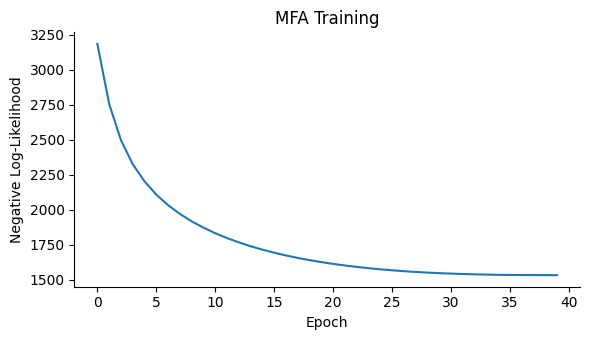

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(losses, linewidth=1.5)
ax.set_xlabel("Epoch")
ax.set_ylabel("Negative Log-Likelihood")
ax.set_title("MFA Training")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

## Part 5: Interpret Components via Logit Lens

In [13]:
with torch.no_grad():
    all_resp = []
    for i in range(0, activations.shape[0], 2000):
        batch = activations[i : i + 2000].to(device)
        all_resp.append(mfa.responsibilities(batch).cpu())
    all_resp = torch.cat(all_resp, dim=0)
    all_assignments = all_resp.argmax(dim=-1)

counts = torch.zeros(K)
for k in range(K):
    counts[k] = (all_assignments == k).sum()

top_components = counts.argsort(descending=True)[:10]
print("Top 10 components by size:")
for rank_idx, k in enumerate(top_components):
    k = k.item()
    print(f"\n{'=' * 60}")
    print(
        f"Component {k} ({counts[k].int().item()} activations, {100 * counts[k] / len(all_assignments):.1f}%)"
    )

    centroid = mfa.mus[k].detach().cpu()
    print(f"  Centroid top tokens: ", end="")
    for tok, val in logit_lens(centroid, top_k=8):
        print(f"'{tok.strip()}'({val:.1f})", end="  ")
    print()

    W_k = mfa.Ws[k].detach().cpu()
    for r in range(min(3, rank)):
        direction = W_k[:, r]
        pos_tokens = logit_lens(direction, top_k=5)
        neg_tokens = logit_lens(-direction, top_k=5)
        pos_str = ", ".join(f"'{t.strip()}'" for t, v in pos_tokens[:4])
        neg_str = ", ".join(f"'{t.strip()}'" for t, v in neg_tokens[:4])
        print(f"  Loading {r}: [{neg_str}] ←→ [{pos_str}]")

Top 10 components by size:

Component 56 (2388 activations, 7.8%)
  Centroid top tokens: ''(161.5)  'and'(154.4)  '('(147.8)  'in'(142.3)  '.'(140.9)  ','(138.6)  'I'(136.0)  'a'(130.7)  
  Loading 0: ['heres', '?).', 'despite', 'given'] ←→ ['lene', 'Himself', 'selves', 'licking']
  Loading 1: ['olicies', 'pean', 'tole', 'avorable'] ←→ ['πο', 'acity', 'setattr', 'pylint']
  Loading 2: ['ippings', 'ibility', 'average', 'els'] ←→ ['scill', 'rette', 'entieth', 'Uzbek']

Component 5 (1320 activations, 4.3%)
  Centroid top tokens: '.'(172.1)  ','(170.7)  ''(164.3)  'and'(160.2)  '-'(155.6)  '('(155.2)  'in'(145.7)  'a'(137.5)  
  Loading 0: ['', 'ively', 'date', 'iteritems'] ←→ ['serializer', 'cmds', 'serializers', 'tokenizer']
  Loading 1: ['outheastern', 'interpre', '||(', 'abouts'] ←→ ['as', 'by', 'while', 'off']
  Loading 2: ['ustaining', 'ieu', 'allion', 'ificial'] ←→ ['foundland', 'ingly', 'reason', 'acerb']

Component 17 (1211 activations, 3.9%)
  Centroid top tokens: ''(147.0)  '('(

In [14]:
print("Tokens assigned to top components:\n")
for k in top_components[:5]:
    k = k.item()
    mask = all_assignments == k
    component_tokens = token_ids[mask]
    sample_idx = torch.randperm(component_tokens.shape[0])[:30]
    decoded = [
        tokenizer.decode([t.item()]).strip() for t in component_tokens[sample_idx]
    ]
    unique_toks = list(dict.fromkeys(decoded))[:20]
    print(f"Component {k} ({counts[k].int().item()} tokens):")
    print(f"  {', '.join(repr(t) for t in unique_toks)}")
    print()

Tokens assigned to top components:

Component 56 (2388 tokens):
  ',', 'the', '', '"', ';', '('

Component 5 (1320 tokens):
  'holds', 'elling', 'arranging', 'relates', 'gave', 'relate', 'led', 'developing', 'keeps', 'help', 'changed', 'available', 'related', 'using', 'Familiarize', 'enhance', 'relying', 'create', 'delivered', 'began'

Component 17 (1211 tokens):
  '!', ').', '.', '?'

Component 40 (996 tokens):
  'us', 'we', 'you', 'they', 'it', 'them', 'me', 'You', 'It', 'I', 'Him', 'We'

Component 47 (962 tokens):
  'and', 'or', '.'



## Part 6: Decompose Activations

In [15]:
with torch.no_grad():
    test_x = activations[:2000].to(device)
    decomp = mfa.decompose(test_x)

centroids = decomp["centroids"].cpu()
local_offsets = decomp["local_offsets"].cpu()
noise = decomp["noise"].cpu()
x_cpu = test_x.cpu()

recon = centroids + local_offsets + noise
assert torch.allclose(recon, x_cpu, atol=1e-4), "Decomposition must reconstruct x!"

centroid_norm = centroids.norm(dim=-1).mean()
offset_norm = local_offsets.norm(dim=-1).mean()
noise_norm = noise.norm(dim=-1).mean()
total_norm = x_cpu.norm(dim=-1).mean()

print("Decomposition magnitude analysis:")
print(f"  ||x||          = {total_norm:.3f}")
print(
    f"  ||centroid||   = {centroid_norm:.3f} ({100 * centroid_norm / total_norm:.1f}%)"
)
print(f"  ||local_offset|| = {offset_norm:.3f} ({100 * offset_norm / total_norm:.1f}%)")
print(f"  ||noise||      = {noise_norm:.3f} ({100 * noise_norm / total_norm:.1f}%)")
print(
    f"\nInterpretable fraction (centroid + offset): {100 * (centroid_norm + offset_norm) / total_norm:.1f}%"
)

Decomposition magnitude analysis:
  ||x||          = 139.804
  ||centroid||   = 118.430 (84.7%)
  ||local_offset|| = 42.499 (30.4%)
  ||noise||      = 49.283 (35.3%)

Interpretable fraction (centroid + offset): 115.1%


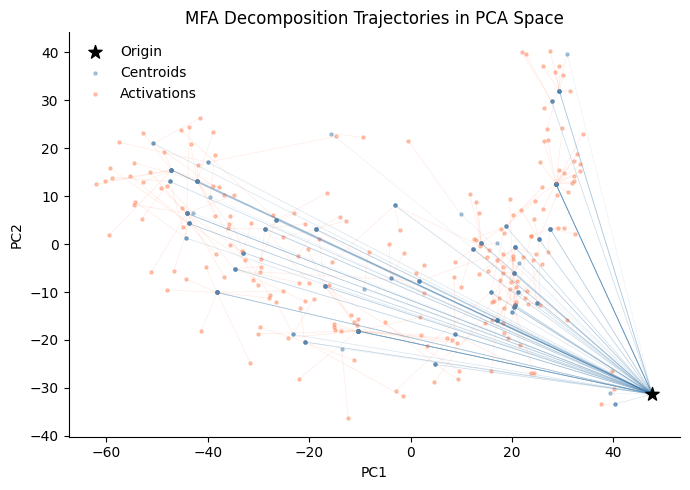

Blue: origin → centroid (which region?)
Red:  centroid → activation (local variation within region)


In [16]:
from sklearn.decomposition import PCA

n_show = 200
pca = PCA(n_components=2).fit(x_cpu[:1000].numpy())

origin_2d = pca.transform(np.zeros((1, d_model)))
centroids_2d = pca.transform(centroids[:n_show].numpy())
full_2d = pca.transform(x_cpu[:n_show].numpy())

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for i in range(n_show):
    ax.plot(
        [origin_2d[0, 0], centroids_2d[i, 0]],
        [origin_2d[0, 1], centroids_2d[i, 1]],
        c="steelblue",
        alpha=0.1,
        linewidth=0.5,
    )
    ax.plot(
        [centroids_2d[i, 0], full_2d[i, 0]],
        [centroids_2d[i, 1], full_2d[i, 1]],
        c="coral",
        alpha=0.15,
        linewidth=0.5,
    )

ax.scatter(*origin_2d.T, c="black", s=100, zorder=5, marker="*", label="Origin")
ax.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    c="steelblue",
    s=5,
    alpha=0.4,
    label="Centroids",
)
ax.scatter(full_2d[:, 0], full_2d[:, 1], c="coral", s=5, alpha=0.4, label="Activations")

ax.legend(frameon=False)
ax.set_title("MFA Decomposition Trajectories in PCA Space")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

print("Blue: origin → centroid (which region?)")
print("Red:  centroid → activation (local variation within region)")

## Part 7: Steering with MFA

In [17]:
def centroid_steer(
    x: Float[Tensor, "batch d"],
    centroid: Float[Tensor, "d"],
    alpha: float,
) -> Float[Tensor, "batch d"]:
    return (1 - alpha) * x + alpha * centroid


def local_offset_steer(
    x: Float[Tensor, "batch d"],
    W_k: Float[Tensor, "d rank"],
    v: Float[Tensor, "rank"],
    alpha: float = 1.0,
) -> Float[Tensor, "batch d"]:
    return x + alpha * (W_k @ v)

In [18]:
target_k = top_components[0].item()

centroid_k = mfa.mus[target_k].detach().cpu()
W_k = mfa.Ws[target_k].detach().cpu()

print(f"Steering toward component {target_k}")
print(f"Centroid promotes: ", end="")
for tok, val in logit_lens(centroid_k, top_k=8):
    print(f"'{tok.strip()}'({val:.1f})", end="  ")
print()

other_mask = all_assignments != target_k
other_acts = activations[other_mask][:500]

print(f"\n--- Centroid Steering (interpolate toward mu_{target_k}) ---")
alphas = [0.0, 0.3, 0.5, 0.7, 1.0]
for alpha in alphas:
    steered = centroid_steer(other_acts, centroid_k, alpha)
    mean_steered = steered.mean(dim=0)
    top_toks = logit_lens(mean_steered, top_k=5)
    tok_str = ", ".join(f"'{t.strip()}'" for t, v in top_toks)
    print(f"  α={alpha:.1f}: {tok_str}")

print(f"\n--- Local Offset Steering (along loading 0 of component {target_k}) ---")
in_mask = all_assignments == target_k
in_acts = activations[in_mask][:500]

strengths = [-3.0, -1.0, 0.0, 1.0, 3.0]
for s in strengths:
    v = torch.zeros(rank)
    v[0] = s
    steered = local_offset_steer(in_acts, W_k, v)
    mean_steered = steered.mean(dim=0)
    top_toks = logit_lens(mean_steered, top_k=5)
    tok_str = ", ".join(f"'{t.strip()}'" for t, v in top_toks)
    print(f"  v[0]={s:+.1f}: {tok_str}")

Steering toward component 56
Centroid promotes: ''(161.5)  'and'(154.4)  '('(147.8)  'in'(142.3)  '.'(140.9)  ','(138.6)  'I'(136.0)  'a'(130.7)  

--- Centroid Steering (interpolate toward mu_56) ---
  α=0.0: ',', '.', '(', 'and', ''
  α=0.3: ',', '', '(', 'and', '.'
  α=0.5: '', 'and', ',', '(', '.'
  α=0.7: '', 'and', '(', ',', '.'
  α=1.0: '', 'and', '(', 'in', '.'

--- Local Offset Steering (along loading 0 of component 56) ---
  v[0]=-3.0: '', 'and', '(', 'in', '.'
  v[0]=-1.0: '', 'and', '(', 'in', '.'
  v[0]=+0.0: '', 'and', '(', 'in', '.'
  v[0]=+1.0: '', 'and', '(', 'in', '.'
  v[0]=+3.0: '', 'and', '(', 'in', '.'


In [19]:
in_mean = activations[in_mask].mean(dim=0)
out_mean = activations[other_mask].mean(dim=0)
diff_mean_dir = in_mean - out_mean
diff_mean_dir = diff_mean_dir / diff_mean_dir.norm()

test_acts = other_acts[:200].to(device)

print("Steering comparison: MFA centroid vs DiffMean direction")
print(f"{'Alpha':<8} {'Centroid NLL':>14} {'DiffMean NLL':>14}")
print("-" * 40)

for alpha in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    with torch.no_grad():
        steered_c = centroid_steer(test_acts, centroid_k.to(device), alpha)
        nll_c = -mfa.log_prob(steered_c).mean().item()

        scale = alpha * (centroid_k.to(device) - test_acts.mean(dim=0)).norm()
        steered_d = test_acts + scale * diff_mean_dir.to(device)
        nll_d = -mfa.log_prob(steered_d).mean().item()

    print(f"{alpha:<8.1f} {nll_c:>14.2f} {nll_d:>14.2f}")

print("\nLower NLL = more on-manifold. Centroid steering should stay more on-manifold")
print("because it interpolates between valid activation positions.")

Steering comparison: MFA centroid vs DiffMean direction
Alpha      Centroid NLL   DiffMean NLL
----------------------------------------
0.0             1660.39        1660.39
0.2             1382.40        1681.84
0.4             1259.44        1743.75
0.6             1154.11        1845.85
0.8              857.64        1987.25
1.0              756.91        2166.27

Lower NLL = more on-manifold. Centroid steering should stay more on-manifold
because it interpolates between valid activation positions.


## Part 8: Multi-Gaussian Concept Neighborhoods

In [20]:
with torch.no_grad():
    centroids_all = mfa.mus.detach().cpu()
    centroid_dists = torch.cdist(centroids_all, centroids_all)

print("Component neighborhoods (nearest centroids in activation space):\n")
for k in top_components[:5]:
    k = k.item()
    dists_k = centroid_dists[k]
    nearest = dists_k.argsort()[1:6]

    parent_toks = logit_lens(centroids_all[k], top_k=5)
    parent_str = ", ".join(f"'{t.strip()}'" for t, v in parent_toks)
    print(f"Component {k}: {parent_str}")

    for neighbor in nearest:
        n = neighbor.item()
        d = dists_k[n].item()
        neighbor_toks = logit_lens(centroids_all[n], top_k=5)
        neighbor_str = ", ".join(f"'{t.strip()}'" for t, v in neighbor_toks)
        print(f"  → {n} (dist={d:.2f}): {neighbor_str}")
    print()

Component neighborhoods (nearest centroids in activation space):

Component 56: '', 'and', '(', 'in', '.'
  → 1 (dist=50.11): '', ',', '(', '.', 'and'
  → 47 (dist=50.20): ',', '', '(', 'I', '.'
  → 48 (dist=50.57): '', ',', '(', '.', 'a'
  → 17 (dist=53.01): '', '(', ',', '', '.'
  → 42 (dist=55.46): '', ',', '.', '(', 'a'

Component 5: '.', ',', '', 'and', '-'
  → 23 (dist=39.21): '.', ',', 'and', '-', ''
  → 6 (dist=41.07): ',', '.', '', '-', 'and'
  → 48 (dist=49.35): '', ',', '(', '.', 'a'
  → 44 (dist=51.44): ',', '.', '', 'and', '('
  → 12 (dist=51.68): '', ',', '.', 'and', 'a'

Component 17: '', '(', ',', '', '.'
  → 1 (dist=48.49): '', ',', '(', '.', 'and'
  → 62 (dist=48.88): '.', '(', ',', '', ''
  → 56 (dist=53.01): '', 'and', '(', 'in', '.'
  → 0 (dist=62.12): '(', ',', '', '', '.'
  → 34 (dist=69.08): ',', '', '-', '(', '.'

Component 40: ',', '.', '', '(', 'in'
  → 56 (dist=62.94): '', 'and', '(', 'in', '.'
  → 6 (dist=65.68): ',', '.', '', '-', 'and'
  → 8 (dist=66.90):

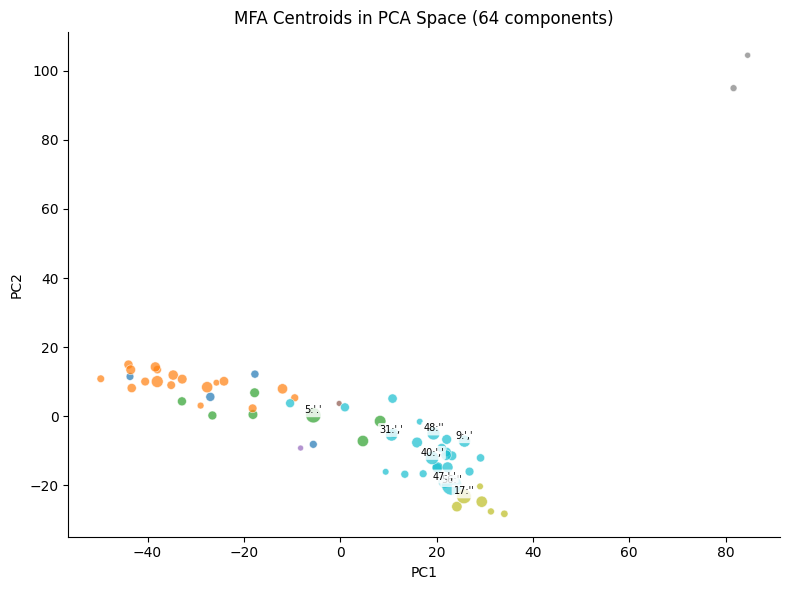

Bubble size ∝ number of assigned activations.
Color = hierarchical cluster of centroids.
Nearby centroids with same color = concept neighborhoods.


In [21]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster, linkage

pca_centroids = PCA(n_components=2).fit_transform(centroids_all.numpy())

Z = linkage(centroids_all.numpy(), method="ward")
cluster_labels = fcluster(Z, t=8, criterion="maxclust")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
scatter = ax.scatter(
    pca_centroids[:, 0],
    pca_centroids[:, 1],
    c=cluster_labels,
    cmap="tab10",
    s=counts.numpy() / counts.max().item() * 200 + 10,
    alpha=0.7,
    edgecolors="white",
    linewidth=0.5,
)

for k in top_components[:8]:
    k = k.item()
    top_tok = logit_lens(centroids_all[k], top_k=1)[0][0].strip()
    ax.annotate(
        f"{k}:'{top_tok}'",
        (pca_centroids[k, 0], pca_centroids[k, 1]),
        fontsize=7,
        ha="center",
        va="bottom",
        bbox=dict(
            boxstyle="round,pad=0.2", facecolor="white", alpha=0.8, edgecolor="none"
        ),
    )

ax.set_title(f"MFA Centroids in PCA Space ({K} components)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

print("Bubble size ∝ number of assigned activations.")
print("Color = hierarchical cluster of centroids.")
print("Nearby centroids with same color = concept neighborhoods.")

## Summary

You've implemented the core components of the MFA paper:

1. **Factor Analysis** — the generative model $x = \mu + Wz + \epsilon$ with Woodbury-efficient log-likelihood
2. **Mixture of Factor Analyzers** — K components with centroids, loadings, shared noise
3. **Component assignment** — responsibilities $R_k(x)$ via Bayes' rule
4. **Activation decomposition** — centroid + local offset + noise (3-part split)
5. **Logit lens interpretation** — centroids encode broad themes, loadings encode fine distinctions
6. **Two types of steering** — centroid interpolation (change region) vs local offset (refine within region)
7. **Concept neighborhoods** — related Gaussians cluster together in centroid space

### Key takeaways from the paper:

- **Beyond single directions**: Concepts have nonlinear, multi-cluster structure. MFA captures this; linear probes and SAEs don't.
- **Interpretability fraction**: MFA decompositions are ~96% interpretable (vs ~29% for SAEs) because the centroid + offset structure is inherently meaningful.
- **Competitive steering**: MFA often outperforms SAEs on causal steering benchmarks, especially for broad concepts.
- **Scaling**: The paper uses K=1K to 32K components. More components split broad Gaussians into finer sub-concepts rather than discovering entirely new structure.

### Things we didn't cover:
- RAVEL/MCQA localization benchmarks with DBM
- Full causal steering evaluation with LLM-as-judge
- Comparison at full scale (100M activations, 32K components)
- Narrow vs broad Gaussian classification
- The SAE decomposition trajectory comparison (Figure 4)